In [9]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [24]:
import os
import json
import glob
import pandas as pd
from pathlib import Path

def load_all_model_results():
    """Load all model fit results from the model_fits directory"""
    results = []
    
    # Find all JSON files in model_fits directory
    json_files = glob.glob("model_fits/**/*.json", recursive=True)

    
    
    for file_path in json_files:
        # if in filename "all_all", skip
        if "all" in os.path.basename(file_path):
            continue
        try:
            with open(file_path, 'r') as f:
                result = json.load(f)
            
            # Extract participant ID and model type from filename if not in data
            filename = os.path.basename(file_path)
            parts = filename.replace('.json', '').split('_')
            #print(parts)
            if 'participantID' not in result:
                result['participantID'] = parts[0]

            
            result['modelType'] = parts[1]+"_"+parts[3]
            
            if parts[2]!="LapseFree":
                #print("Lapse fixed model, skipping")
                continue
            

            results.append(result)
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return results

# Load all results
all_results = load_all_model_results()
print(f"Loaded {len(all_results)} model fit results")

# Convert to DataFrame for easier analysis
df_results = pd.DataFrame(all_results)
print(f"Participants: {sorted(df_results['participantID'].unique())}")
print(f"Models: {sorted(df_results['modelType'].unique())}")


Loaded 144 model fit results
Participants: ['as', 'dt', 'hh', 'ip', 'ln1', 'ln2', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']
Models: ['fusionOnlyLogNorm_sharedPrior', 'fusionOnly_sharedPrior', 'gaussian_sharedPrior', 'logLinearMismatch_sharedPrior', 'lognorm_contextualPrior', 'lognorm_sharedPrior', 'probabilityMatchingLogNorm_sharedPrior', 'probabilityMatching_sharedPrior', 'selection_sharedPrior', 'switchingFree_sharedPrior', 'switchingWithConflict_sharedPrior', 'switching_sharedPrior']


In [25]:
def rename_model(df_results, old_name, new_name):
    """Rename a model name across all relevant DataFrames and variables."""
    # Rename in df_results
    df_results['modelType'] = df_results['modelType'].replace(old_name, new_name)
    
    # Rename in best_models_df
    best_models_df['best_model'] = best_models_df['best_model'].replace(old_name, new_name)
    
    # Rename in comparison_table_df
    comparison_table_df.columns = comparison_table_df.columns.map(
        lambda col: col if col[1] != old_name else (col[0], new_name)
    )
    
    # Rename in delta_aic_table
    delta_aic_table.columns = delta_aic_table.columns.str.replace(old_name, new_name)
    
    # Rename in ll_table
    ll_table.columns = ll_table.columns.str.replace(old_name, new_name)
    
    # Rename in simple_table
    simple_table.columns = simple_table.columns.str.replace(old_name, new_name)
    
    # Update participant_best_models
    global participant_best_models
    participant_best_models = [
        new_name if model == old_name else model for model in participant_best_models
    ]
    
    # Update ll_best_models
    global ll_best_models
    ll_best_models = [
        new_name if model == old_name else model for model in ll_best_models
    ]
    
    # Print confirmation
    print(f"Model name '{old_name}' has been renamed to '{new_name}'")

# Example usage
rename_model(df_results, 'probabilityMatchingLogNorm_sharedPrior', 'prob-Matching-Log')
rename_model(df_results, 'probabilityMatchingLogNorm', 'prob-Matching')
rename_model(df_results, 'probabilityMatching_sharedPrior', 'prob-Matching-Gauss')
rename_model(df_results, 'switchingFree_sharedPrior', 'Free Switching')
rename_model(df_results, 'switching_sharedPrior', 'Noise Dep. Switching')
rename_model(df_results, 'switchingWithConflict_sharedPrior', 'Noise Dep. Switching + Conflict')
rename_model(df_results, 'fusionOnly_sharedPrior', 'Fusion Only')
rename_model(df_results, 'fusionOnlyLogNorm_sharedPrior', 'Fusion Only-Log')
rename_model(df_results, 'lognorm_sharedPrior', 'Log-Space Causal')
rename_model(df_results, 'gaussian_sharedPrior', 'Gaussian-Space Causal')
rename_model(df_results, 'lognorm_contextualPrior', 'Log-Space Causal + Context')




Model name 'probabilityMatchingLogNorm_sharedPrior' has been renamed to 'prob-Matching-Log'
Model name 'probabilityMatchingLogNorm' has been renamed to 'prob-Matching'
Model name 'probabilityMatching_sharedPrior' has been renamed to 'prob-Matching-Gauss'
Model name 'switchingFree_sharedPrior' has been renamed to 'Free Switching'
Model name 'switching_sharedPrior' has been renamed to 'Noise Dep. Switching'
Model name 'switchingWithConflict_sharedPrior' has been renamed to 'Noise Dep. Switching + Conflict'
Model name 'fusionOnly_sharedPrior' has been renamed to 'Fusion Only'
Model name 'fusionOnlyLogNorm_sharedPrior' has been renamed to 'Fusion Only-Log'
Model name 'lognorm_sharedPrior' has been renamed to 'Log-Space Causal'
Model name 'gaussian_sharedPrior' has been renamed to 'Gaussian-Space Causal'
Model name 'lognorm_contextualPrior' has been renamed to 'Log-Space Causal + Context'


In [26]:
# Create comprehensive comparison table
def create_model_comparison_table(df_results):
    """Create a detailed comparison table of all model fits"""
    
    # Pivot table to compare models side by side
    comparison_cols = ['AIC', 'BIC', 'logLikelihood', 'n_conditions']
    
    summary_table = df_results.pivot_table(
        index='participantID', 
        columns='modelType', 
        values=comparison_cols,
        aggfunc='first'
    )
    
    return summary_table

# Create the comparison table
comparison_table = create_model_comparison_table(df_results)
comparison_table_df=comparison_table.copy()
comparison_table_df

AIC                               \
modelType     Free Switching  Fusion Only Fusion Only-Log   
participantID                                               
as               2256.817665  2263.345437     2252.784688   
dt               2552.903011  2565.341083     2553.622813   
hh               1204.688062  1195.850193     1194.891691   
ip               2412.120769  2460.905237     2404.078456   
ln1              1177.270207  1155.994138     1167.040492   
ln2              2177.282303  2202.909958     2172.429201   
mh               2438.360836  2484.289394     2427.261128   
ml               2505.417079  2511.040793     2510.355144   
mt               2204.548044  2229.582293     2195.662851   
oy               2326.807734  2349.704795     2325.546404   
qs               2500.423150  2544.869563     2495.252281   
sx               2140.309309  2152.265325     2149.645484   

                                                      \
modelType     Gaussian-Space Causal Log-Space Causal   
participantID                                          
as                      2261.304338      2256.924335   
dt                      2557.767546      2554.957272   
hh                      1205.147493      1201.714419   
ip                      2448.722277      2405.628163   
ln1                     1154.115752      1168.387763   
ln2                     2199.935258      2176.844062   
mh                      2460.008404      2435.201329   
ml                      2497.081123      2510.309442   
mt                      2212.898957      2200.263864   
oy                      2342.707849      2330.423325   
qs                      2528.941767      2499.493968   
sx                      2149.253130      2155.610053   

                                                               \
modelType     Log-Space Causal + Context Noise Dep. Switching   
participantID                                                   
as                           2263.121318          2265.876716   
dt                           2560.158634          2561.533629   
hh                           1200.494798          1204.953014   
ip                           2411.827519          2463.951618   
ln1                          1175.271027          1173.415772   
ln2                          2187.972030          2215.971735   
mh                           2432.071672          2501.097562   
ml                           2510.857864          2516.305148   
mt                           2203.133573          2222.667674   
oy                           2339.644664          2349.979606   
qs                           2505.856238          2543.845889   
sx                           2163.218901          2166.997284   

                                                                             \
modelType     Noise Dep. Switching + Conflict logLinearMismatch_sharedPrior   
participantID                                                                 
as                                2268.334887                   2267.678639   
dt                                2572.934870                   2559.242249   
hh                                1210.256625                   1207.937372   
ip                                2470.964306                   2415.656094   
ln1                               1160.509485                   1187.446115   
ln2                               2208.636090                   2187.439502   
mh                                2524.226002                   2440.958873   
ml                                2530.269857                   2547.796173   
mt                                2242.349850                   2210.646225   
oy                                2352.713330                   2342.185560   
qs                                2532.137876                   2512.368823   
sx                                2135.481734                   2169.746267   

                                   ...    n_conditions                        \
modelType     prob-Matchin

In [27]:
# Find best model for each participant (lowest AIC)
def find_best_models(df_results):
    """Find the best fitting model for each participant based on AIC"""
    best_models = []
    
    for participant in df_results['participantID'].unique():
        participant_data = df_results[df_results['participantID'] == participant]
        
        if len(participant_data) > 0:
            # Find model with lowest AIC
            best_idx = participant_data['AIC'].idxmin()
            best_model = participant_data.loc[best_idx]

            # delta AIC and BIC compared to the best model
            for _, row in participant_data.iterrows():
                if row['modelType'] != best_model['modelType']:
                    delta_AIC = row['AIC'] - best_model['AIC']
                    delta_BIC = row['BIC'] - best_model['BIC']
                    print(f"Participant {participant}, Model {row['modelType']} vs Best Model {best_model['modelType']}: ΔAIC={delta_AIC:.2f}, ΔBIC={delta_BIC:.2f}")
            
            best_models.append({
                'participantID': participant,
                'best_model': best_model['modelType'],
                'AIC': best_model['AIC'],
                'BIC': best_model['BIC'],
                'logLikelihood': best_model['logLikelihood'],
                'delta_AIC': delta_AIC,
                'delta_BIC': delta_BIC
            })
    
    return pd.DataFrame(best_models)

# Find best models
best_models_df = find_best_models(df_results)
print("\nBest Model for Each Participant (based on AIC):")
print("=" * 60)
print(best_models_df.round(3))

# Model performance summary
print(f"\nModel Performance Summary:")
print("=" * 40)
model_counts = best_models_df['best_model'].value_counts()
for model, count in model_counts.items():
    percentage = (count / len(best_models_df)) * 100
    print(f"{model}: {count} participants ({percentage:.1f}%)")

Participant sx, Model Free Switching vs Best Model Noise Dep. Switching + Conflict: ΔAIC=4.83, ΔBIC=-3.30
Participant sx, Model Log-Space Causal vs Best Model Noise Dep. Switching + Conflict: ΔAIC=20.13, ΔBIC=16.31
Participant sx, Model logLinearMismatch_sharedPrior vs Best Model Noise Dep. Switching + Conflict: ΔAIC=34.26, ΔBIC=30.01
Participant sx, Model Fusion Only vs Best Model Noise Dep. Switching + Conflict: ΔAIC=16.78, ΔBIC=-0.25
Participant sx, Model Fusion Only-Log vs Best Model Noise Dep. Switching + Conflict: ΔAIC=14.16, ΔBIC=-2.58
Participant sx, Model selection_sharedPrior vs Best Model Noise Dep. Switching + Conflict: ΔAIC=20.83, ΔBIC=17.01
Participant sx, Model Noise Dep. Switching vs Best Model Noise Dep. Switching + Conflict: ΔAIC=31.52, ΔBIC=27.26
Participant sx, Model prob-Matching-Gauss vs Best Model Noise Dep. Switching + Conflict: ΔAIC=21.07, ΔBIC=16.82
Participant sx, Model Log-Space Causal + Context vs Best Model Noise Dep. Switching + Conflict: ΔAIC=27.74, ΔBIC

Participants sorted by sum of delta_AIC across all models (lowest to highest):
Delta_AIC sums: {'hh': 81.23906544888882, 'dt': 97.3628236571526, 'as': 108.88257115851047, 'oy': 186.77232671547517, 'mt': 206.2223307617778, 'sx': 227.67877103949104, 'ln2': 250.02372296847625, 'ln1': 262.42377947383125, 'qs': 290.7964182695059, 'ip': 352.58090049748444, 'ml': 382.40859801248416, 'mh': 425.01488237279773}


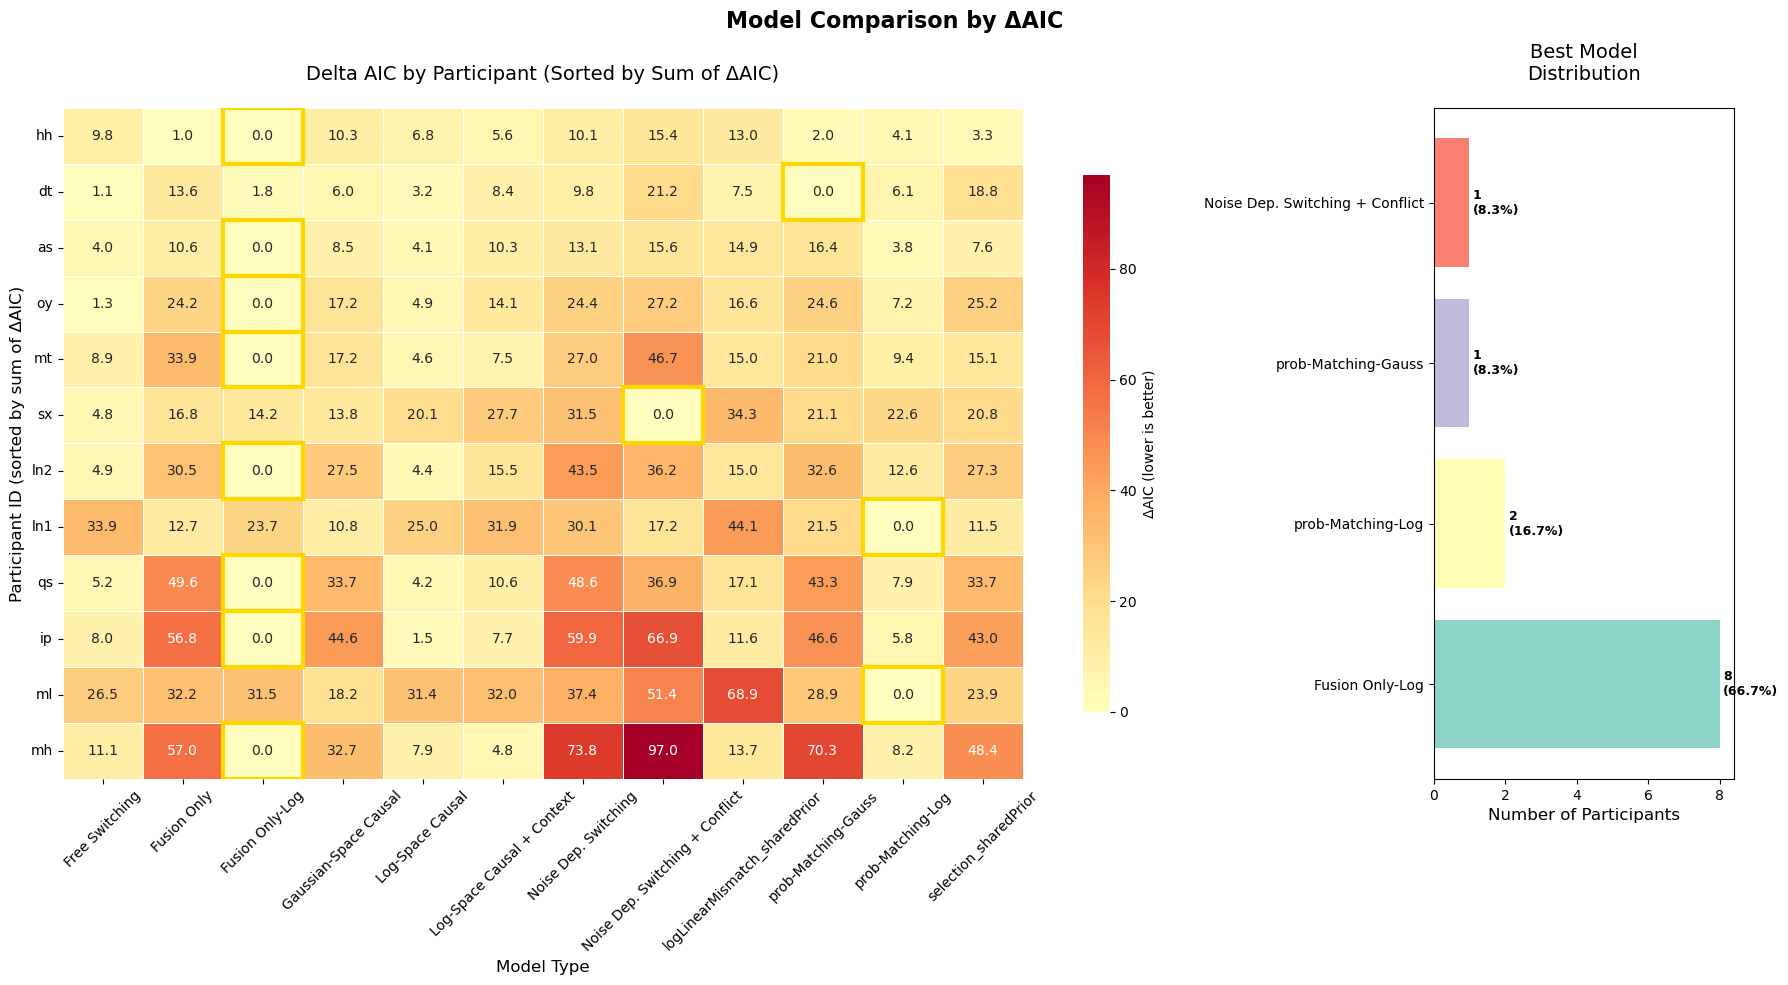


PARTICIPANT RANKING TABLE (sorted by sum of ΔAIC across all models)
Rank Participant  Sum ΔAIC   Best Model         Min ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    hh           81.2       Fusion Only-Log    0.0        Poor fit       
2    dt           97.4       prob-Matching-Gauss 0.0        Poor fit       
3    as           108.9      Fusion Only-Log    0.0        Poor fit       
4    oy           186.8      Fusion Only-Log    0.0        Poor fit       
5    mt           206.2      Fusion Only-Log    0.0        Poor fit       
6    sx           227.7      Noise Dep. Switching + Conflict 0.0        Poor fit       
7    ln2          250.0      Fusion Only-Log    0.0        Poor fit       
8    ln1          262.4      prob-Matching-Log  0.0        Poor fit       
9    qs           290.8      Fusion Only-Log    0.0        Poor fit       
10   ip           352.6      Fusion Only-Log    0.0        Poor fit       
1

In [28]:
# Calculate delta_AIC for each model relative to the best model per participant
df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())

# Sort participants by sum of delta_AIC across all models (lower sum = better overall performance)
participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
sorted_participants = participant_delta_sums.index.tolist()
print("Participants sorted by sum of delta_AIC across all models (lowest to highest):")
print(f"Delta_AIC sums: {participant_delta_sums.to_dict()}")

import matplotlib.pyplot as plt
import seaborn as sns

# Create enhanced table-style visualization
def plot_sorted_model_comparison_table(df_results):
    """Create a comprehensive table plot with participants sorted by sum of delta_AIC"""
    
    # Calculate delta_AIC for each model relative to the best model
    df_results['delta_AIC'] = df_results.groupby('participantID')['AIC'].transform(lambda x: x - x.min())
    
    # Sort participants by sum of delta_AIC across all models
    participant_delta_sums = df_results.groupby('participantID')['delta_AIC'].sum().sort_values()
    sorted_participants = participant_delta_sums.index.tolist()
    
    # Create the pivot table with sorted participants
    df_delta_aic = df_results.pivot(index='participantID', columns='modelType', values='delta_AIC')
    df_delta_aic = df_delta_aic.reindex(sorted_participants)
    
    # Find best model for each participant
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['AIC'].idxmin(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by ΔAIC', fontsize=16, fontweight='bold')
    
    # Main heatmap with delta_AIC values
    sns.heatmap(df_delta_aic, 
                annot=True, 
                fmt='.1f', 
                cmap='RdYlBu_r', 
                center=0,
                ax=ax1,
                cbar_kws={'label': 'ΔAIC (lower is better)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Delta AIC by Participant (Sorted by Sum of ΔAIC)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by sum of ΔAIC)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_delta_aic.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a star or border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='gold', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Model\nDistribution', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    # # Add legend explaining the gold borders
    # ax1.text(0.02, 0.98, '★ Gold border = Best model for participant', 
    #          transform=ax1.transAxes, fontsize=10, 
    #          bbox=dict(boxstyle='round,pad=0.3', facecolor='gold', alpha=0.7),
    #          verticalalignment='top')
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by sum of ΔAIC across all models)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Sum ΔAIC':<10} {'Best Model':<18} {'Min ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        min_delta_aic = participant_data['delta_AIC'].min()
        best_model = participant_data.loc[participant_data['AIC'].idxmin(), 'modelType']
        
        if sum_delta_aic <= 5:
            performance = "Excellent fit"
        elif sum_delta_aic <= 15:
            performance = "Good fit"
        elif sum_delta_aic <= 30:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {sum_delta_aic:<10.1f} {best_model:<18} {min_delta_aic:<10.1f} {performance:<15}")
    
    return df_delta_aic, best_models, participant_delta_sums

# Create the enhanced visualization
delta_aic_table, participant_best_models, delta_sums = plot_sorted_model_comparison_table(df_results)

In [29]:
# Simple Model Comparison Table with Log Likelihoods
def create_simple_comparison_table(df_results):
    """Create a simple comparison table focused on log likelihoods"""
    
    # Pivot to show log likelihoods for each participant-model combination
    log_likelihood_table = df_results.pivot(
        index='participantID', 
        columns='modelType', 
        values='logLikelihood'
    )
    
    # Sort participants by ID for consistent ordering
    log_likelihood_table = log_likelihood_table.sort_index()
    
    return log_likelihood_table

# Create the simple comparison table
simple_table = create_simple_comparison_table(df_results)

print("Model Comparison Table - Log Likelihoods")
print("=" * 80)
print("Higher values indicate better fit")
print("=" * 80)
print()

# Display with better formatting
pd.set_option('display.float_format', '{:.2f}'.format)
display(simple_table)

# Reset display options
pd.reset_option('display.float_format')

Model Comparison Table - Log Likelihoods
Higher values indicate better fit



modelType,Free Switching,Fusion Only,Fusion Only-Log,Gaussian-Space Causal,Log-Space Causal,Log-Space Causal + Context,Noise Dep. Switching,Noise Dep. Switching + Conflict,logLinearMismatch_sharedPrior,prob-Matching-Gauss,prob-Matching-Log,selection_sharedPrior
participantID,,,,,,,,,,,,
as,-1120.41,-1125.67,-1120.39,-1121.65,-1119.46,-1121.56,-1123.94,-1124.17,-1124.84,-1125.58,-1119.28,-1121.19
dt,-1268.45,-1276.67,-1270.81,-1269.88,-1268.48,-1270.08,-1271.77,-1276.47,-1270.62,-1266.89,-1269.93,-1276.32
hh,-594.34,-591.93,-591.45,-593.57,-591.86,-590.25,-593.48,-595.13,-594.97,-589.43,-590.47,-590.09
ip,-1198.06,-1224.45,-1196.04,-1215.36,-1193.81,-1195.91,-1222.98,-1225.48,-1198.83,-1216.34,-1195.96,-1214.53
ln1,-580.64,-572.00,-577.52,-568.06,-575.19,-577.64,-577.71,-570.25,-584.72,-573.43,-562.67,-568.42
ln2,-1080.64,-1095.45,-1080.21,-1090.97,-1079.42,-1083.99,-1098.99,-1094.32,-1084.72,-1093.53,-1083.50,-1090.85
mh,-1211.18,-1236.14,-1207.63,-1221.00,-1208.60,-1206.04,-1241.55,-1252.11,-1211.48,-1239.77,-1208.74,-1228.83
ml,-1244.71,-1249.52,-1249.18,-1239.54,-1246.15,-1245.43,-1249.15,-1255.13,-1264.90,-1244.90,-1230.44,-1242.38
mt,-1094.27,-1108.79,-1091.83,-1097.45,-1091.13,-1091.57,-1102.33,-1111.17,-1096.32,-1099.31,-1093.53,-1096.37


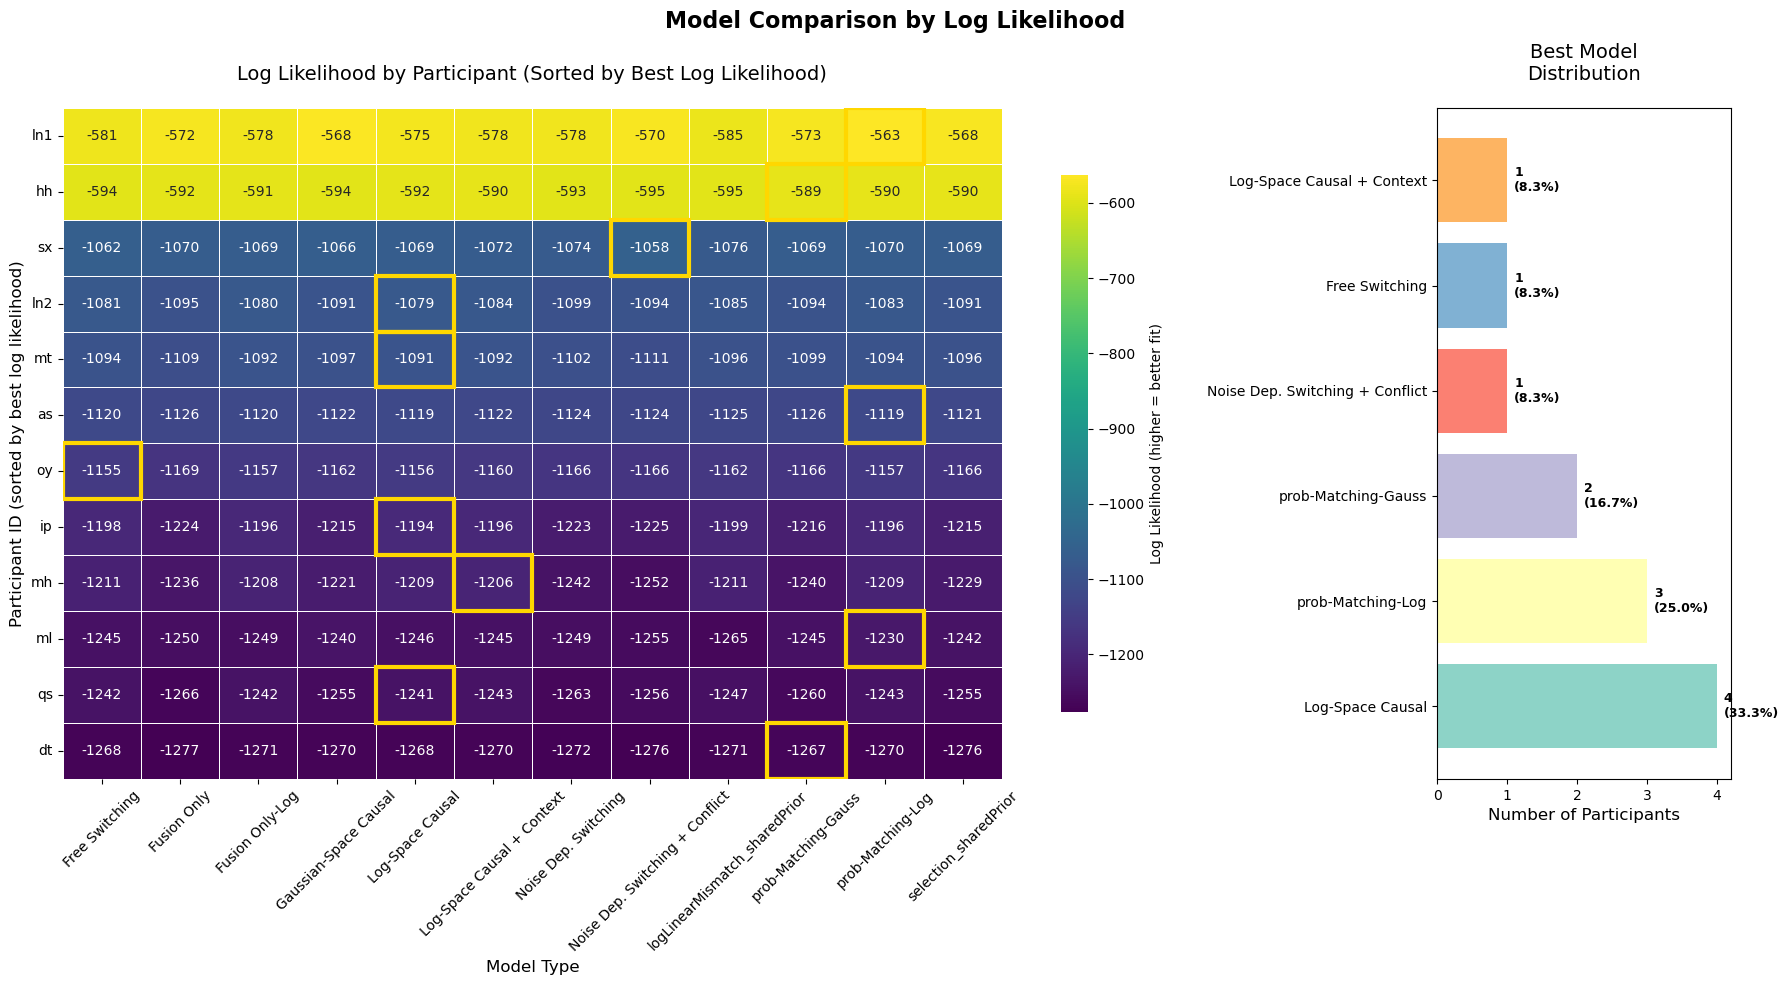


PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)
Rank Participant  Best LL    Best Model         Sum ΔAIC   Performance    
------------------------------------------------------------------------------------------
1    ln1          -563       prob-Matching-Log  262.4      Excellent fit  
2    hh           -589       prob-Matching-Gauss 81.2       Excellent fit  
3    sx           -1058      Noise Dep. Switching + Conflict 227.7      Moderate fit   
4    ln2          -1079      Log-Space Causal   250.0      Moderate fit   
5    mt           -1091      Log-Space Causal   206.2      Moderate fit   
6    as           -1119      prob-Matching-Log  108.9      Moderate fit   
7    oy           -1155      Free Switching     186.8      Moderate fit   
8    ip           -1194      Log-Space Causal   352.6      Moderate fit   
9    mh           -1206      Log-Space Causal + Context 425.0      Poor fit       
10   ml           -1230      prob-Matching-Log  382.4      Poor fit       
11 

In [30]:
# Plot Log Likelihood Comparison Table (similar to ΔAIC visualization)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_log_likelihood_comparison_table(df_results):
    """Create a comprehensive log likelihood comparison plot similar to ΔAIC visualization"""
    
    # Sort participants by their best (highest) log likelihood values
    participant_best_ll = df_results.groupby('participantID')['logLikelihood'].max().sort_values(ascending=False)
    sorted_participants = participant_best_ll.index.tolist()
    
    # Create the pivot table with sorted participants for log likelihoods
    df_log_likelihood = df_results.pivot(index='participantID', columns='modelType', values='logLikelihood')
    df_log_likelihood = df_log_likelihood.reindex(sorted_participants)
    
    # Find best model for each participant (highest log likelihood)
    best_models = []
    for participant in sorted_participants:
        participant_data = df_results[df_results['participantID'] == participant]
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        best_models.append(best_model)
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [4, 1]})
    fig.suptitle('Model Comparison by Log Likelihood', fontsize=16, fontweight='bold')
    
    # Main heatmap with log likelihood values
    sns.heatmap(df_log_likelihood, 
                annot=True, 
                fmt='.0f', 
                cmap='viridis', 
                ax=ax1,
                cbar_kws={'label': 'Log Likelihood (higher = better fit)', 'shrink': 0.8},
                linewidths=0.5,
                linecolor='white')
    
    ax1.set_title('Log Likelihood by Participant (Sorted by Best Log Likelihood)', fontsize=14, pad=20)
    ax1.set_ylabel('Participant ID (sorted by best log likelihood)', fontsize=12)
    ax1.set_xlabel('Model Type', fontsize=12)
    
    # Rotate x-axis labels for better readability
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', rotation=0, labelsize=10)
    
    # Add best model indicators (gold borders)
    for i, (participant, best_model) in enumerate(zip(sorted_participants, best_models)):
        # Find column index of best model
        model_cols = df_log_likelihood.columns.tolist()
        if best_model in model_cols:
            col_idx = model_cols.index(best_model)
            # Add a gold border to highlight best model
            rect = plt.Rectangle((col_idx, i), 1, 1, fill=False, edgecolor='gold', lw=3)
            ax1.add_patch(rect)
    
    # Side panel: Best model summary
    best_model_counts = pd.Series(best_models).value_counts()
    colors = plt.cm.Set3(range(len(best_model_counts)))
    
    bars = ax2.barh(range(len(best_model_counts)), best_model_counts.values, color=colors)
    ax2.set_yticks(range(len(best_model_counts)))
    ax2.set_yticklabels(best_model_counts.index, fontsize=10)
    ax2.set_xlabel('Number of Participants', fontsize=12)
    ax2.set_title('Best Model\nDistribution', fontsize=14, pad=20)
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, best_model_counts.values)):
        percentage = (count / len(sorted_participants)) * 100
        ax2.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                f'{count}\n({percentage:.1f}%)', 
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()
    
    # Print summary table
    print("\n" + "="*90)
    print("PARTICIPANT RANKING TABLE (sorted by best Log Likelihood)")
    print("="*90)
    print(f"{'Rank':<4} {'Participant':<12} {'Best LL':<10} {'Best Model':<18} {'Sum ΔAIC':<10} {'Performance':<15}")
    print("-"*90)
    
    for rank, participant in enumerate(sorted_participants, 1):
        participant_data = df_results[df_results['participantID'] == participant]
        sum_delta_aic = participant_data['delta_AIC'].sum()
        best_ll = participant_data['logLikelihood'].max()
        best_model = participant_data.loc[participant_data['logLikelihood'].idxmax(), 'modelType']
        
        if best_ll >= -600:
            performance = "Excellent fit"
        elif best_ll >= -900:
            performance = "Good fit"
        elif best_ll >= -1200:
            performance = "Moderate fit"
        else:
            performance = "Poor fit"
            
        print(f"{rank:<4} {participant:<12} {best_ll:<10.0f} {best_model:<18} {sum_delta_aic:<10.1f} {performance:<15}")
    
    return df_log_likelihood, best_models

# Create the enhanced log likelihood visualization
ll_table, ll_best_models = plot_log_likelihood_comparison_table(df_results)